### Import libraries

In [2]:
from matplotlib import pyplot as plt

import numpy as np

from iminuit import Minuit

from joblib import Parallel, delayed

import os

import constants, functions

### First Chi2 estimation for window

In [5]:
n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

minimizer = Minuit(functions.chi2_rsd, omega=0.315, sigma=0.811, gamma=0.55)

minimizer.limits["omega"] = (om_min,om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)

result = minimizer.migrad()

RuntimeError: 3 values given for 7 function parameter(s)

In [4]:
print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.3f} ± {minimizer.errors['omega']:.4f}")
print(f"σ8,0 = {minimizer.values['sigma']:.3f} ± {minimizer.errors['sigma']:.4f}")
print(f"γ = {minimizer.values['gamma']:.3f} ± {minimizer.errors['gamma']:.3f}\n")

print(result)


Résultats du fit :
Chi2 = 8.06 

Paramètres estimés :
Ωm = 0.050 ± 0.1162
σ8,0 = 0.536 ± 0.0553
γ = 0.060 ± 0.051

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.056                      │              Nfcn = 261              │
│ EDM = 1.59e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴────────────

### Plotting $f\sigma_8(z)$ evolution

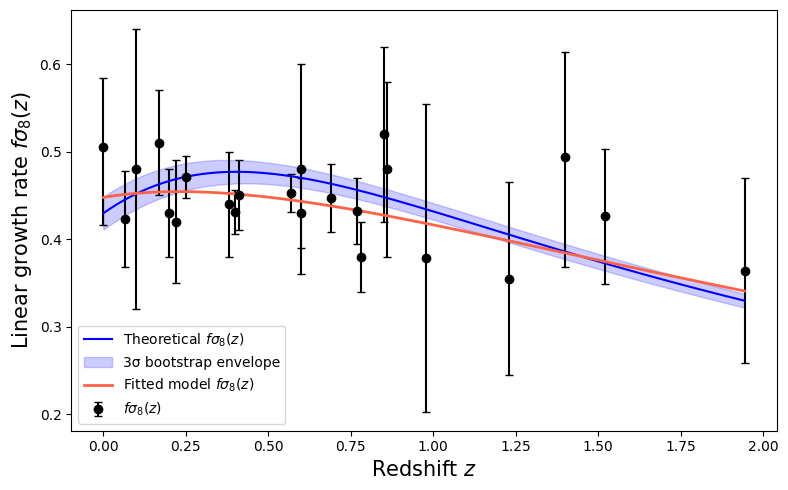

In [5]:
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline

### Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(constants.z_data), max(constants.z_data), nb_points_th)

### Bootstrap
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = functions.growth(z_range, omega_0 = omega0, sigma_8_0 = sigma8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)

### Approximation
# spline = UnivariateSpline(constants.z_data, constants.fs8_data, s=len(constants.fs8_data))
# fs8_approx = spline(z_range)
fs8_approx = functions.growth(z_range, gamma=minimizer.values['gamma'], omega_0=minimizer.values['omega'], sigma_8_0=minimizer.values['sigma'])

### Plotting
plt.figure(figsize=(8, 5))
# Data distribution
plt.errorbar(constants.z_data, constants.fs8_data, yerr=constants.fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)
# Theoretical function
growth_values = functions.growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
# Enveloppe
plt.fill_between(z_range, fsigma8_mean-3*fsigma8_std, fsigma8_mean+3*fsigma8_std, color='blue', alpha=0.2, label='3σ bootstrap envelope')
# Approximate function
plt.plot(z_range, fs8_approx, color='tomato', lw=2, label=r"Fitted model $f\sigma_8(z)$")
# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()


plt.show()

### Calculations

In [5]:
def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.migrad()
    return minimizer.fval

chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, functions.chi2_rsd) for omega in omega_vals for sigma in sigma_vals)

chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)

chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, functions.chi2_rsd) for omega in omega_vals for gamma in gamma_vals)

chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)

chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(sigma, gamma, om_min, om_max, functions.chi2_rsd) for sigma in sigma_vals for gamma in gamma_vals)

chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)

np.savez("../output/chi2_RSD/chi2_grids.npz", grid1=chi2_grid1, grid2=chi2_grid2, grid3=chi2_grid3)

### Load data

In [3]:
data_rsd = np.load("../output/chi2_RSD/chi2_grids.npz")

chi2_grid1 = data_rsd['grid1']
chi2_grid2 = data_rsd['grid2']
chi2_grid3 = data_rsd['grid3']

n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

### Plot

(0.5373737373737374, 0.05)
Incertitude $\sigma_8$ : xmin = 0.46, xmax = 0.78
Incertitude $\Omega_m$ : ymin = 0.05, ymax = 0.42

(0.05555555555555558, 0.05)
Incertitude $\gamma$ : xmin = 0.01, xmax = 0.71
Incertitude $\Omega_m$ : ymin = 0.05, ymax = 0.42

(0.05555555555555558, 0.5292929292929294)
Incertitude $\gamma$ : xmin = 0.01, xmax = 0.74
Incertitude $\sigma_8$ : ymin = 0.47, ymax = 0.78



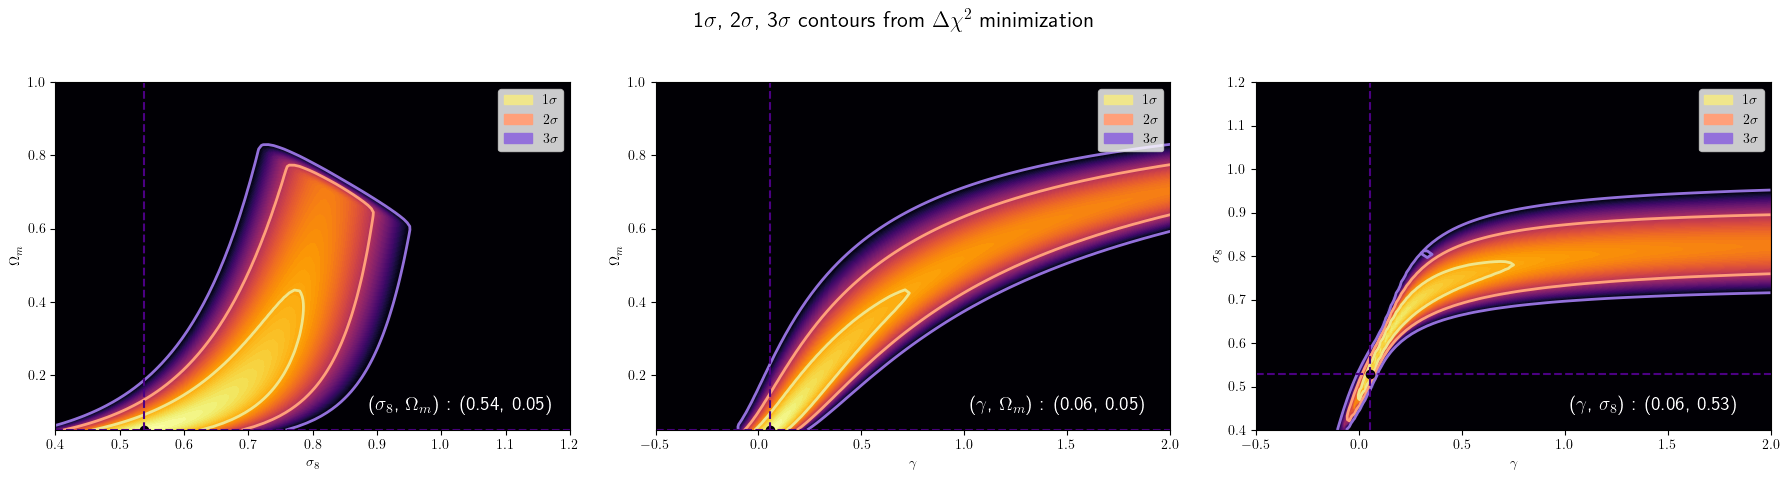

In [5]:
from matplotlib.patches import Patch

def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f}")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f}\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
                verticalalignment='top', horizontalalignment='left')


        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.rcParams.update({
    "text.usetex": True
})
plt.show()